## Run the Self-Organizing Map
Training sample: KiDS <br>
Labeling sample: GAMA <br>
___

First, load the data

In [1]:
from astropy.io import fits
from astropy.table import Table, hstack

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from matplotlib.patches import Rectangle

plt.rcParams.update({
    'font.family':       'serif',
    'font.size':         24,
    'font.serif':        'Georgia',
    'axes.labelsize':    'large',
    'mathtext.fontset':  'stix',
    'axes.linewidth':    1.5,
    'xtick.direction':   'in',
    'ytick.direction':   'in',
    'xtick.major.size':  5,
    'ytick.major.size':  5,
    'xtick.major.width': 1.2,
    'ytick.major.width': 1.2,
})

In [2]:
#Load in KiDS data
with fits.open('/data2/lsajkov/mpdg/data_products/KiDS/KiDS_SOM_catalog_17Jul24.fits') as cat:
    KiDS_cat = Table(cat[1].data)

#Load in GAMA data
with fits.open('/data2/lsajkov/mpdg/data_products/GAMA/GAMA_SOM_training_catalog_17Jul24.fits') as cat:
    GAMA_cat = Table(cat[1].data)

In [15]:
#Select the needed data
KiDS_mag_cut = KiDS_cat['r_mag'] < 20.5
KiDS_redshift_cut = KiDS_cat['redshift'] < 0.4

input_cat = KiDS_cat[KiDS_redshift_cut & KiDS_mag_cut]

GAMA_redshift_cut = GAMA_cat['redshift'] < 0.4
labels_cat = GAMA_cat[GAMA_redshift_cut]

input_data = Table([
                    input_cat['r_mag'],
                    # (input_cat['r_mag'] - input_cat['r_mag'].min())/(input_cat['r_mag'].max() - input_cat['r_mag'].min()),
                    input_cat['ug_col'],
                    input_cat['gr_col'],
                    input_cat['ri_col'],
                    input_cat['redshift']
                    ],
            names = [
                     'r_mag',
                     'ug_col',
                     'gr_col',
                     'ri_col',
                     'redshift'
                     ])
input_stds = Table([
                    input_cat['r_mag_err'],
                    input_cat['ug_col_err'],
                    input_cat['gr_col_err'],
                    input_cat['ri_col_err'],
                    input_cat['redshift_err']
                    ],
           names = [
                    'r_mag_err',
                    'ug_col_err',
                    'gr_col_err',
                    'ri_col_err',
                    'redshift_err'
                    ])

for key in input_stds.keys(): input_stds[key] = np.sqrt(input_stds[key])

input_labels = Table([
                      labels_cat['r_mag'],
                      # (labels_cat['r_mag'] - labels_cat['r_mag'].min())/(labels_cat['r_mag'].max() - labels_cat['r_mag'].min()),
                      labels_cat['ug_col'],
                      labels_cat['gr_col'],
                      labels_cat['ri_col'],
                      labels_cat['redshift'],
                      labels_cat['mstar'],
                      ],
             names = [
                      'r_mag',
                      'ug_col',
                      'gr_col',
                      'ri_col',
                      'redshift',
                      'mstar',
                      ])

input_label_stds = Table([
                          labels_cat['r_mag_err'],
                          labels_cat['ug_col_err'],
                          labels_cat['gr_col_err'],
                          labels_cat['ri_col_err'],
                          [0.01] * len(labels_cat),
                          labels_cat['mstar_err'] * np.log(10),
                          ],
                 names = [
                          'r_mag_err',
                          'ug_col_err',
                          'gr_col_err',
                          'ri_col_err',
                          'redshift_err',
                          'mstar_err',
                          ])

# for key in input_label_stds.keys(): input_label_stds[key] = np.sqrt(input_label_stds[key]) 

print(f'Len of input data: {len(input_data)}')
print(f'Len of labeling data: {len(input_labels)}')

Len of input data: 155180
Len of labeling data: 46682


Select & normalize data

In [ ]:
#Select the needed data NORMALIZED
KiDS_mag_cut = KiDS_cat['r_mag'] < 20.5
KiDS_redshift_cut = KiDS_cat['redshift'] < 1
KiDS_size_cut = KiDS_cat['half_light_radius'] < 1e10

input_cat = KiDS_cat[KiDS_redshift_cut &\
                     KiDS_mag_cut &\
                     KiDS_size_cut]

GAMA_redshift_cut = GAMA_cat['redshift'] < 1
labels_cat = GAMA_cat[GAMA_redshift_cut]

input_data = Table([
                    2 * (input_cat['r_mag'] - input_cat['r_mag'].min())/(input_cat['r_mag'].max() - input_cat['r_mag'].min()) - 1,
                    (input_cat['ug_col'] - input_cat['ug_col'].mean())/input_cat['ug_col'].std(),
                    (input_cat['gr_col'] - input_cat['gr_col'].mean())/input_cat['gr_col'].std(),
                    (input_cat['ri_col'] - input_cat['ri_col'].mean())/input_cat['ri_col'].std(),
                    input_cat['redshift'] - np.median(input_cat['redshift']),
                #     (input_cat['half_light_radius'] - input_cat['half_light_radius'].mean())/input_cat['half_light_radius'].std()
                    ],
            names = [
                     'r_mag',
                     'ug_col',
                     'gr_col',
                     'ri_col',
                     'redshift',
                #      'radius_50'
                     ])
input_stds = Table([
                    2 * input_cat['r_mag_err']/(input_cat['r_mag'].max() - input_cat['r_mag'].min()),
                    input_cat['ug_col_err']/input_cat['ug_col'].std(),
                    input_cat['gr_col_err']/input_cat['gr_col'].std(),
                    input_cat['ri_col_err']/input_cat['ri_col'].std(),
                    input_cat['redshift_err'],
                #     [0.1] * len(input_cat)
                    ],
           names = [
                    'r_mag_err',
                    'ug_col_err',
                    'gr_col_err',
                    'ri_col_err',
                    'redshift_err',
                #     'radius_50_err'
                    ])

input_labels = Table([
                      2 * (labels_cat['r_mag'] - labels_cat['r_mag'].min())/(labels_cat['r_mag'].max() - labels_cat['r_mag'].min()) - 1,
                      (labels_cat['ug_col'] - labels_cat['ug_col'].mean())/labels_cat['ug_col'].std(),
                      (labels_cat['gr_col'] - labels_cat['gr_col'].mean())/labels_cat['gr_col'].std(),
                      (labels_cat['ri_col'] - labels_cat['ri_col'].mean())/labels_cat['ri_col'].std(),
                      labels_cat['redshift'],
                #       (labels_cat['half_light_radius'] - labels_cat['half_light_radius'].mean())/labels_cat['half_light_radius'].std(),
                      np.log10(labels_cat['mstar']),
                      ],
             names = [
                      'r_mag',
                      'ug_col',
                      'gr_col',
                      'ri_col',
                      'redshift',
                #       'radius_50',
                      'mstar',
                      ])

input_label_stds = Table([
                          2 * labels_cat['r_mag_err']/(labels_cat['r_mag'].max() - labels_cat['r_mag'].min()),
                          labels_cat['ug_col_err']/labels_cat['ug_col'].std(),
                          labels_cat['gr_col_err']/labels_cat['gr_col'].std(),
                          labels_cat['ri_col_err']/labels_cat['ri_col'].std(),
                          [0.01] * len(labels_cat),
                          labels_cat['mstar_err']/(labels_cat['mstar'] * np.log(10)),
                          ],
                 names = [
                          'r_mag_err',
                          'ug_col_err',
                          'gr_col_err',
                          'ri_col_err',
                          'redshift_err',
                        #   'radius_50_err',
                          'mstar_err',
                          ])

print(f'Len of input data: {len(input_data)}')
print(f'Len of labeling data: {len(input_labels)}')

___

Initialize the SOM

In [16]:
from mpdg_som import SelfOrganizingMap

In [17]:
#Set parameters
name = 'mass_profile_dwarf_galaxies' #name of the SOM

mapsize   = [40, 40] #size of the map. pass as a list of dimensions OR as an integer (also pass number of dimensions)
dimension = None

initialization         = 'pca' #random or pca (principal component analysis)
termination            = 'either' #when to stop learning. maximum_steps = stop when maximum_steps have elapsed. error_thresh = stop when the error is below this threshold. either = stop when either condition is fulfilled
learning_rate_function = 'power_law' #which learning rate function to use. currently implemented: power_law
neighborhood_function  = 'gaussian' #which neighborhood function to use. currently implemented: gaussian
error_estimator        = 'quantization_error' #which error estimation function to use. currently implemented: max_misalignment

learning_rate = 0.1 #used to adjust the learning rate function
kernel_spread = 2 #used to adjust the neighborhood function
maximum_steps = 20 #used to adjust the learning rate and neighborhood functions
error_thresh  = 0.05 #used to stop the SOM if termination = 'error thresh'

In [18]:
#Declare the SOM
SOM = SelfOrganizingMap(
    name                   = name,
    mapsize                = mapsize,
    dimension              = dimension,
    initialization         = initialization,
    termination            = termination,
    learning_rate_function = learning_rate_function,
    neighborhood_function  = neighborhood_function,
    error_estimator        = error_estimator,
    learning_rate          = learning_rate,
    kernel_spread          = kernel_spread,
    maximum_steps          = maximum_steps,
    error_thresh           = error_thresh
)

In [7]:
data_cut = -1 #use up to this much of the data (-1 for entire dataset)
if data_cut != -1:
    randomized_idx = np.arange(0, len(input_data))
    np.random.shuffle(randomized_idx)
    randomized_data_idx  = randomized_idx[:data_cut]
    randomized_label_idx = randomized_idx[data_cut:]

SOM.load_data(input_data[:data_cut],
              variable_names = [
                                'r_mag',
                                'ug_col',
                                'gr_col',
                                'ri_col',
                                'redshift',
                                # 'radius'
                                ])
# SOM.normalize_data()

SOM.load_standard_deviations(input_stds[:data_cut])
# SOM.normalize_standard_deviations()

SOM.data_statistics()

| Data statistics 
total entries: 252888

stat	r_mag	ug_col	gr_col	ri_col	redshift	
min	18.000	-0.962	-0.919	-0.954	0.010	
max	24.120	1.999	0.665	1.430	0.390	
mean	20.084	0.905	0.360	0.147	0.087	
median	20.164	0.919	0.366	0.145	0.040	
std	1.039	0.254	0.137	0.100	0.078	

In [8]:
#Initialize the SOM
SOM.build_SOM()


| SOM. Step 0. Initialization: pca
| Initial rms error: 3.099


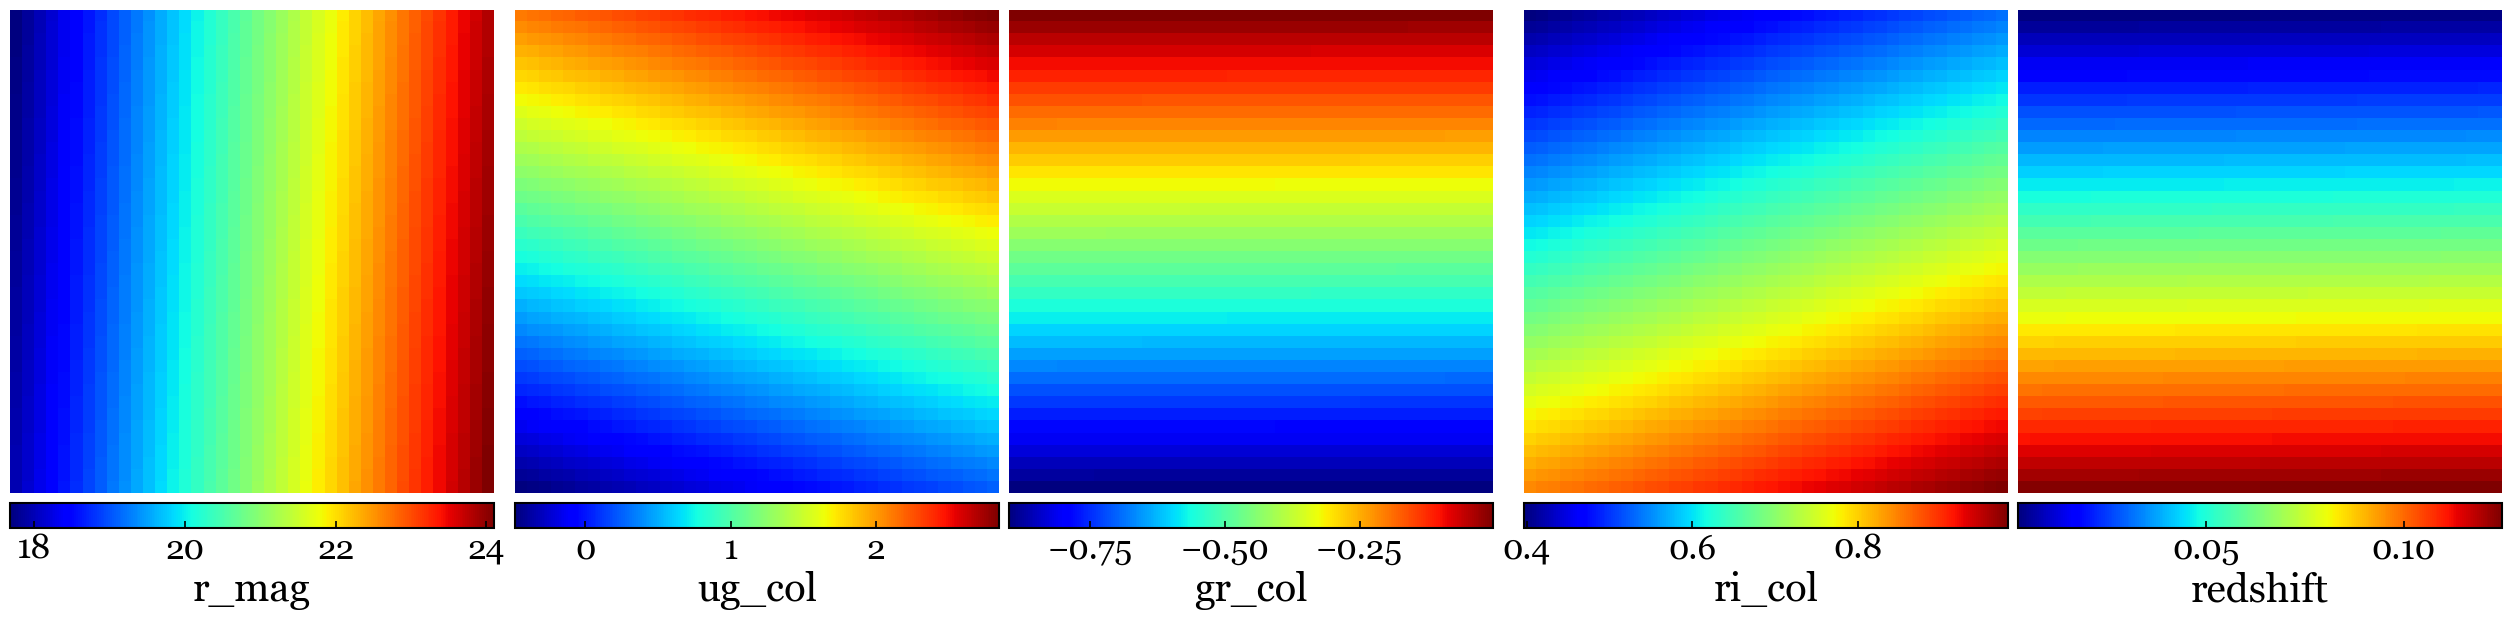

In [9]:
#Visualize SOM before training
SOM.show_map(cmap = 'jet')

#Look at initial quantization error
from mpdg_som_utils import SOM_ErrorEstimators

initial_quant_error = SOM_ErrorEstimators.quantization_error(SOM.weights_map,
                                                             SOM.data,
                                                             SOM.bmu_indices)
print(f'| Initial rms error: {initial_quant_error:.3f}')

(array([2.5963e+04, 0.0000e+00, 1.8989e+04, 0.0000e+00, 0.0000e+00,
        7.0591e+04, 0.0000e+00, 1.3846e+04, 0.0000e+00, 0.0000e+00,
        7.0910e+03, 0.0000e+00, 0.0000e+00, 5.7950e+03, 0.0000e+00,
        4.3660e+03, 0.0000e+00, 0.0000e+00, 6.9850e+03, 0.0000e+00,
        0.0000e+00, 5.6190e+03, 0.0000e+00, 6.4860e+03, 0.0000e+00,
        0.0000e+00, 6.4220e+03, 0.0000e+00, 0.0000e+00, 5.7090e+03,
        0.0000e+00, 4.2690e+03, 0.0000e+00, 0.0000e+00, 5.1210e+03,
        0.0000e+00, 0.0000e+00, 6.3190e+03, 0.0000e+00, 3.3800e+03,
        0.0000e+00, 0.0000e+00, 3.4230e+03, 0.0000e+00, 0.0000e+00,
        5.4700e+03, 0.0000e+00, 3.8670e+03, 0.0000e+00, 0.0000e+00,
        2.3781e+04, 0.0000e+00, 0.0000e+00, 2.4670e+03, 0.0000e+00,
        1.9020e+03, 0.0000e+00, 0.0000e+00, 1.9770e+03, 0.0000e+00,
        0.0000e+00, 3.9770e+03, 0.0000e+00, 1.5170e+03, 0.0000e+00,
        0.0000e+00, 1.6220e+03, 0.0000e+00, 0.0000e+00, 1.5410e+03,
        0.0000e+00, 2.7310e+03, 0.0000e+00, 0.00

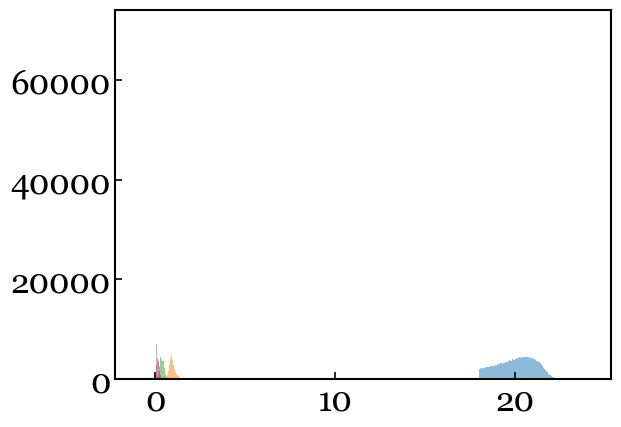

In [10]:
plt.hist(SOM.data[:, 0],
        bins = 'auto', alpha = 0.5)
plt.hist(SOM.data[:, 1],
        bins = 'auto', alpha = 0.5)
plt.hist(SOM.data[:, 2],
        bins = 'auto', alpha = 0.5)
plt.hist(SOM.data[:, 3],
        bins = 'auto', alpha = 0.5)
plt.hist(SOM.data[:, 4],
        bins = 'auto', alpha = 0.5)


In [11]:
#Train the som
SOM.train()

Step 1 complete. Error: 0.410                                   
Step 2 complete. Error: 0.335                                   
Step 3 complete. Error: 0.287                                   
Step 4 complete. Error: 0.249                                   
Step 5 complete. Error: 0.290                                   
Step 6 complete. Error: 0.308                                   
Step 7 complete. Error: 0.263                                   
Step 8 complete. Error: 0.210                                   
Step 9 complete. Error: 0.202                                   
Step 10 complete. Error: 0.292                                   
Step 11 complete. Error: 0.231                                   
Step 12 complete. Error: 0.194                                   
Step 13 complete. Error: 0.172                                   
Step 14 complete. Error: 0.169                                   
Step 15 complete. Error: 0.161                                   
Step 16 complete. E

0.1354373073811106


| SOM. Step 20. Initialization: pca


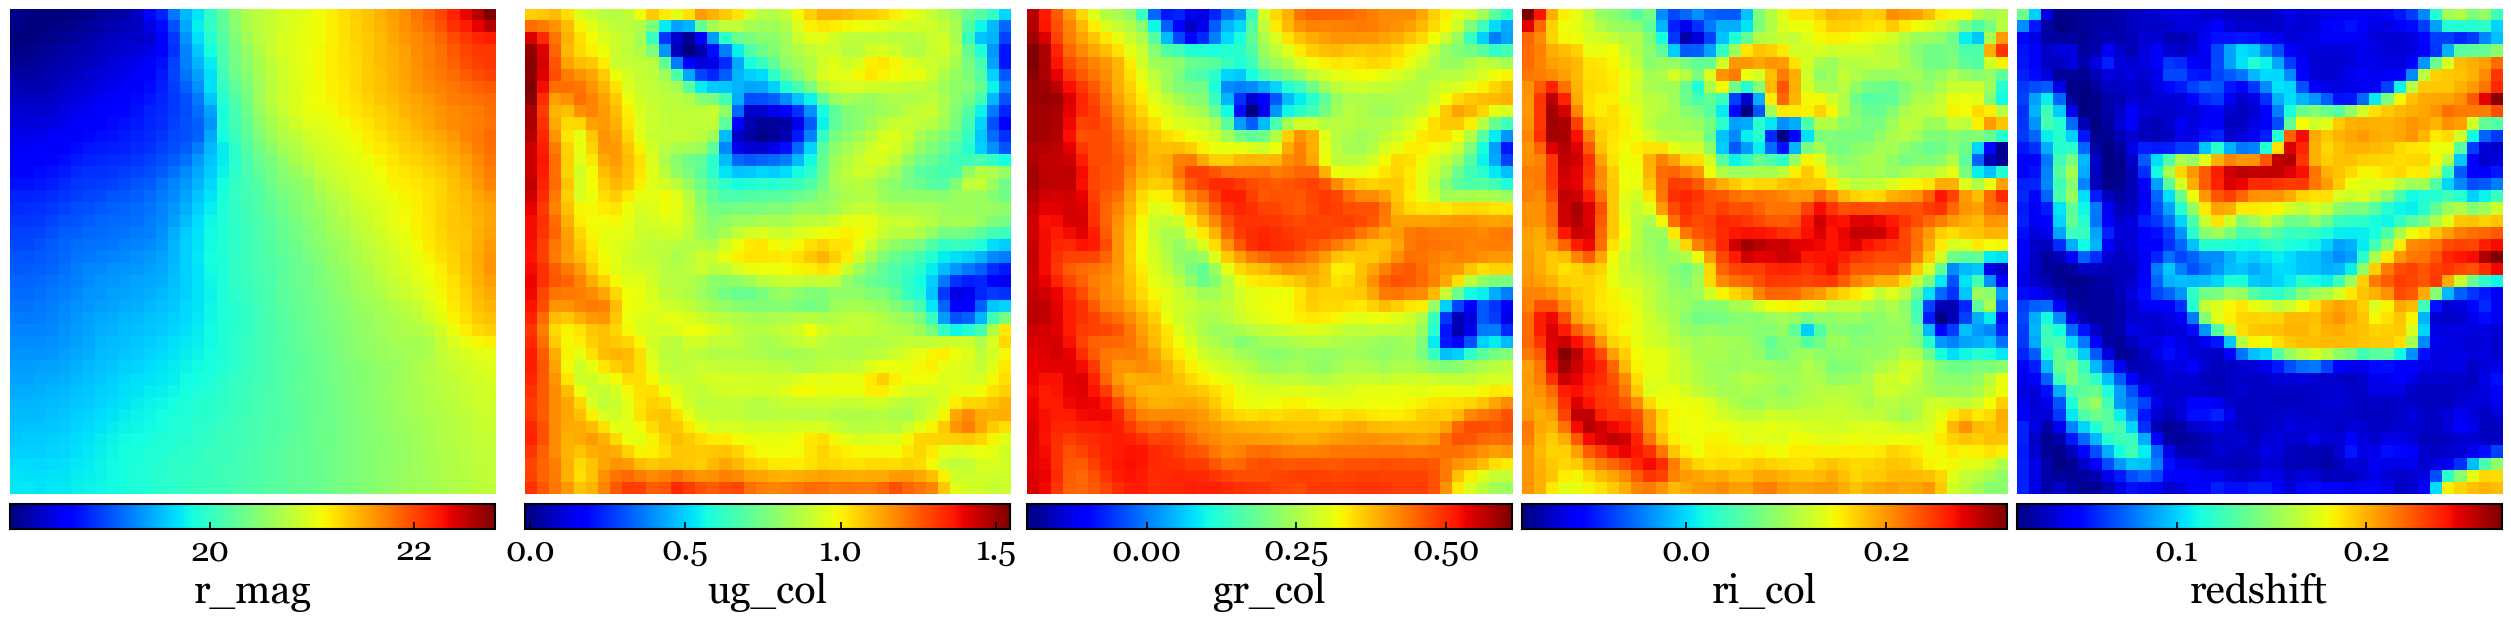

In [12]:
#Visualize the SOM after training
SOM.show_map(cmap = 'jet')


| SOM. Step 20. Initialization: pca


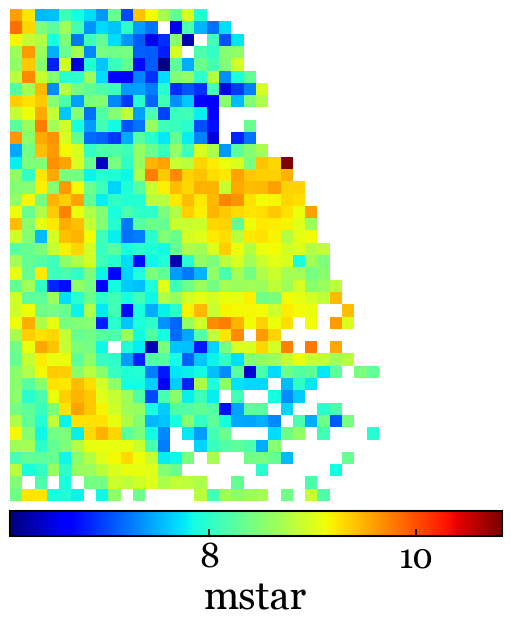

In [13]:
#Label the cells in the map with external parameters. Visualize the labeled map.
SOM.load_labeling_data(input_labels,
                       parameter_names = ['mstar'])
# SOM.normalize_labeling_data()

SOM.load_labeling_standard_deviations(input_label_stds)
# SOM.normalize_labeling_standard_deviations()

SOM.label_map()
# SOM.label_map(pdr = 1000,
#               sigmas_data= [0.1, 0.0075],
#               sigmas_add = [0, 0.0025])

SOM.show_map(show_labeled = True, log_norm = ['mstar'],
             cmap = 'jet')

Text(0.5, 1.0, 'Mean occupancy: 52.6')

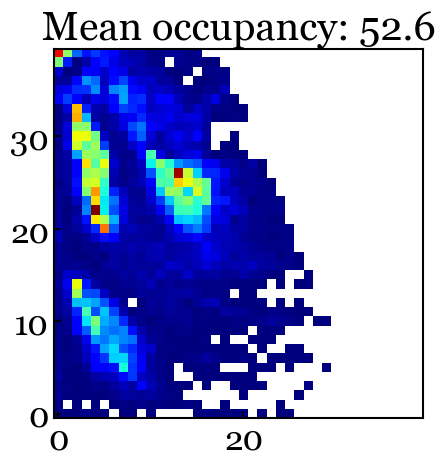

In [14]:
occupancy_map = np.full(SOM.mapsize, np.nan)
for cell, values in np.ndenumerate(SOM.labeled_map_values[..., 0, 0]):
    if len(values) > 0:
        occupancy_map[cell] = len(values)

plt.imshow(occupancy_map,
    origin = 'lower', cmap = 'jet')
plt.title(f'Mean occupancy: {np.nanmean(occupancy_map):.1f}')

In [ ]:
SOM.predict(SOM.labeling_data[:, :SOM.data_dim],
            np.sqrt(SOM.label_variances[:, :SOM.data_dim]))

In [ ]:
SOM.save_outputs('/data2/lsajkov/mpdg/saved_soms',
                 save_weights = True, save_parameters = True)

In [ ]:
np.save('/data2/lsajkov/mpdg/saved_soms/prediction_results',
        SOM.prediction_results, allow_pickle = True)

In [ ]:
np.save('/data2/lsajkov/mpdg/saved_soms/labeling_data',
        SOM.labeling_data, allow_pickle = True)

___

Look at prediction results

In [ ]:
mstar_pred = np.log10(SOM.prediction_results[:, 0])
# redshift_pred = SOM.prediction_results[:, 1]

In [ ]:
fig = plt.figure(figsize = (12, 10))
ax = fig.add_subplot()

vals, bins = np.histogram(mstar_pred, bins = 50,
                          range = [np.nanmin(mstar_pred), np.nanmax(mstar_pred)],
                          density = True)

ax.stairs(vals, bins,
          color = 'black', linewidth = 3,
          label = 'GAMA predicted')

ax.hist(np.log10(SOM.labeling_data[:, SOM.data_dim]),
        bins = bins, density = True, zorder = 0,
        color = 'green', alpha = 0.25,
        label = 'GAMA true')

ax.set_xlabel('log($M_*/M_{\odot}$)')
ax.set_ylabel('$dN/dM$')

ax.legend(frameon = False)

In [ ]:
fig = plt.figure(figsize = (12, 10))
ax = fig.add_subplot()

vals, bins = np.histogram(redshift_pred, bins = 50,
                          range = [np.nanmin(redshift_pred), np.nanmax(redshift_pred)],
                          density = True)

ax.stairs(vals, bins,
          color = 'black', linewidth = 3,
          label = 'GAMA predicted')

ax.hist(SOM.labeling_data[:, SOM.data_dim + 1],
        bins = bins, density = True, zorder = 0,
        color = 'green', alpha = 0.25,
        label = 'GAMA true')

ax.set_xlabel('$z$')
ax.set_ylabel('$dN/dz$')

ax.legend(frameon = False)

___

Compare predictions to inputs

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
fig = plt.figure(figsize = (10, 12))

ax = fig.add_subplot()

hb = ax.hexbin(SOM.labeling_data[:, SOM.data_dim],
               SOM.prediction_results[:, 0],
               mincnt = 1, cmap = 'jet')

MAD = np.nansum(np.abs(SOM.labeling_data[:, SOM.data_dim] - SOM.prediction_results[:, 0]))/(len(SOM.prediction_results) - np.sum(np.isnan(SOM.prediction_results), axis = 0)[0])
# ax.scatter(SOM.labeling_data[:, SOM.data_dim][lo_stripe_idx],
#            SOM.prediction_results[:, 0][lo_stripe_idx],
#            color = 'green', s = 50, facecolor = 'none')

# ax.scatter(SOM.labeling_data[:, SOM.data_dim][hi_stripe_idx],
#            SOM.prediction_results[:, 0][hi_stripe_idx],
#            color = 'red', s = 50, facecolor = 'none')

ax.axline([10, 10], slope = 1, color = 'red')

ax.set_xlim(6, 12)
ax.set_ylim(6, 12)
ax.set_xticks(np.arange(6, 12.5, 0.5))

ax.set_xlabel('GAMA log$_{10} (M_*/M_{\odot})$\nTrue')
ax.set_ylabel('Predicted\nSOM log$_{10} (M_*/M_{\odot})$')

ax.text(0.65, 0.05,
        f'MAD: {MAD:.3f} dex',
        transform = ax.transAxes)

fig.colorbar(ax = ax, mappable = hb,
             location = 'top', pad = 0.01,
             label = '$N_{\mathrm{galaxies}}$')

In [ ]:
np.sum((SOM.prediction_results[:, 1] > 0.33) & (SOM.labeling_data[:, -1] > 0.33) )/len(SOM.prediction_results) * 100

In [ ]:
fig = plt.figure(figsize = (10, 12))

ax = fig.add_subplot()

hb = ax.hexbin(SOM.labeling_data[:, SOM.data_dim + 1],
               SOM.prediction_results[:, 1],
               mincnt = 1, cmap = 'jet')

MAD = np.nansum(np.abs(SOM.labeling_data[:, SOM.data_dim + 1] - SOM.prediction_results[:, 1]))/(len(SOM.prediction_results) - np.sum(np.isnan(SOM.prediction_results), axis = 0)[0])

# ax.scatter(SOM.labeling_data[:, SOM.data_dim + 1][lo_stripe_idx],
#            SOM.prediction_results[:, 1][lo_stripe_idx],
#            color = 'green', s = 50, facecolor = 'none')

# ax.scatter(SOM.labeling_data[:, SOM.data_dim + 1][hi_stripe_idx],
#            SOM.prediction_results[:, 1][hi_stripe_idx],
#            color = 'red', s = 50, facecolor = 'none')

ax.axline([0, 0], slope = 1, color = 'red')

ax.set_xlim(0, 0.105)
ax.set_ylim(0, 0.105)

ax.set_xlabel('GAMA redshift\nTrue')
ax.set_ylabel('Predicted\nSOM redshift')

ax.text(0.65, 0.05,
        f'MAD: {MAD:.3f} dex',
        transform = ax.transAxes)

# ax.axhline(0.33, color = 'black')
# ax.axvline(0.33, color = 'black')

fig.colorbar(ax = ax, mappable = hb,
             location = 'top', pad = 0.01,
             label = '$N_{\mathrm{galaxies}}$')

In [ ]:
SOM_zs = SOM.prediction_results[:, 1]

lo_stripe_idx = (SOM_zs < 0.4) & (SOM_zs > 0.35)
hi_stripe_idx = (SOM_zs < 0.6) & (SOM_zs > 0.5)

hi_stripe_r_mag = input_catalog_complete[-int(data_cut/2):][hi_stripe_idx]['r_mag']
lo_stripe_r_mag = input_catalog_complete[-int(data_cut/2):][lo_stripe_idx]['r_mag']

In [ ]:
fig = plt.figure(figsize = (12, 10))
ax = fig.add_subplot()

ax.hist(lo_stripe_r_mag, bins = 'auto',
        histtype = 'step', color = 'green', linewidth = 5)

ax.set_xlabel('$r$-magnitude')

In [ ]:
fig = plt.figure(figsize = (12, 10))
ax = fig.add_subplot()

ax.hist(hi_stripe_r_mag, bins = 'auto',
        histtype = 'step', color = 'red', linewidth = 5)

ax.set_xlabel('$r$-magnitude')